In [2]:
# MNIST immage classification
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
# mnist
from sklearn.datasets.base import get_data_home 
print (get_data_home())

C:\Users\ishant.wankhede\scikit_learn_data


> MNIST : setting up the dataset.

Success!
{'DESCR': 'mldata.org dataset: mnist-original', 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'target': array([0., 0., 0., ..., 9., 9., 9.]), 'COL_NAMES': ['label', 'data']}
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([0., 0., 0., ..., 9., 9., 9.]))


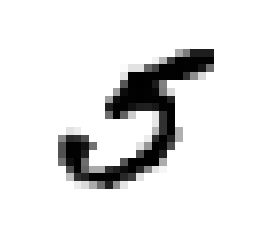

5.0


In [3]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata

from scipy.io import loadmat
# mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
# response = urllib.request.urlopen(mnist_alternative_url)
# with open(mnist_path, "wb") as f:
#     content = response.read()
#     f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

print(mnist)
X, y = mnist["data"], mnist["target"]
print(X,y)
X.shape, y.shape

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

print(y[36000])
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

We will simplify the problem and only try to identify one digit at a time for eg 5. This '5-detector' will be and example of a binary classifier.

In [4]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [5]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

C:\Users\ishant.wankhede\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([False])

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

>Measuring accuracy using Cross Validation

the cross_val_score() function to evaluate your SGDClassifier model using K-fold crossvalidation,
with three folds. 

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9659 , 0.9634 , 0.95935])

Do you think this accuracy number is good? Let try a fit a model which predicts that "no image is 5"

In [7]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9109 , 0.90955, 0.9085 ])

As we can see that even this has high accuracy, that means the dataset is skewed.

In [8]:
# print(len(y_train_5), sum(y_train_5))
# (60000,5421) That means less than 10% is 5

This demonstrates why accuracy is generally not the preferred performance measure for classifiers,
especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent
than others).

### Confusion Matrix https://en.wikipedia.org/wiki/Confusion_matrix

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53947,   632],
       [ 1595,  3826]], dtype=int64)

+ Precision (Accuracy of the positive prediction) : TP / (TP + FP)
    * A trivial way to have perfect precision is to make a single (1/1 = 100%) prediction and to ensure it is correct. This is not that helpfule So precision is used with another metric.
+ Recall (Sensitivty / True Positive Rate) : TP / (TP + FN)
    * Which is the ratio of positive instances that are correctly detected by the classifier.

In [11]:
from sklearn.metrics import precision_score, recall_score
print("Precision ", precision_score(y_train_5, y_train_pred))
print("Recall ", recall_score(y_train_5, y_train_pred))
from sklearn.metrics import f1_score
print("F1 Score ", f1_score(y_train_5, y_train_pred))

('Precision ', 0.8582323912068192)
('Recall ', 0.7057738424644899)
('F1 Score ', 0.7745723251341229)


Precision Recall Tradeoff : Increasing the threshold increases the precision but decreases the recall. Decreasing the threshold increases the recall but decreases the precision. So Looking at the precision recall curve we will choose the best ones.

![](precision_recall_tradeoff2.png)

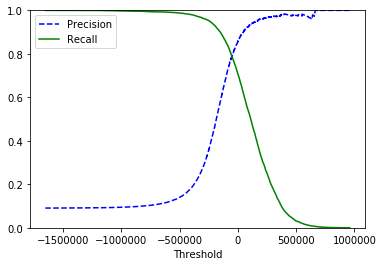

In [12]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [13]:
y_train_pred_90 = (y_scores > 90000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9260911118190507
0.5362479247371333


> If someone says lets achieve 99% Precision, You ask at what precision?

## The ROC Curve
The receiver operating curve is a common used with binary classifier. It is very similar to the precision / recall curve, but instead of plotting precision versus recall, the ROC plot true positive rate against the false positive rate. False positive rate is the ratio of negative instances that are incorrectly classified as positive. Also, It is equal to 1 - True Negative Rate. TNR is also specificity. Hence ROC plot sensitivity (recall / TPR) vs 1 - specificity( 1 - TNR).

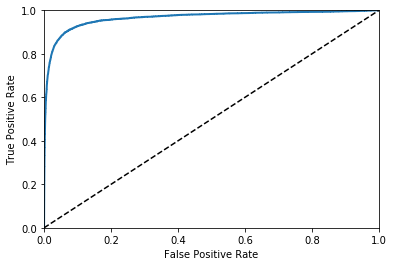

In [14]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is Tradeoff, The higher the recall (TPR), the more False Positives (FPR) the classifier produces. The dotted line represents the ROC of a purely random classifier. A good classifier stays as far away from the dotted line. Towards the top left corner.
One way to compare the classifiers is to use, Area under the curve (AUC). A perfect Classifier will have a aread under the curvee equal to 1. whereas a completely random will have it as 0.5

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9655590665580673

#### Tip: Since the ROC curve is similar to the Precision/Recall curve. How do we decide which ones to use?
+ As a rule of thumb, You should prefer the PR Curve whenever the positive class is rare or when you care more about the false positive than false negatives, and the ROC Curve Otherwise. 


In [16]:
#Comparing RandomForestClassifier and SGDClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [0.1, 0.9],
       [1. , 0. ],
       [1. , 0. ]])

0.9932904840354027


C:\Users\ishant.wankhede\AppData\Local\Continuum\anaconda2\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(self.codes)))


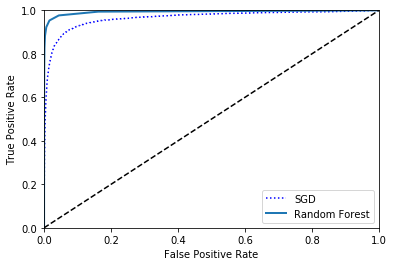

In [17]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)
print(roc_auc_score(y_train_5, y_scores_forest))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

### Multiclassification
+ Binary classification distinguish between two classes, whereas multiclass classification can distinguish between two or more classes.
+ Some classfiers (RF and Naive Bayes) are capable of handling multiple classes directly. Others (Such as SVM or Linear Classifiers) are strictly binary classifiers. However there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.
+ For Eg. One way to create a system that can classify an image into 10 classes is to train 10 different binary classifiers, One for each digit. Then when want to get the decision score from each of the classifier for that image and select the class whose classifier output the highest score. This is called One-Versus-All strategy or one-versus-rest.
+ Another strategy is to train a binary classifier for every pair of digits : one to distinguish 0s and 1s, another to distinguish 0s and 2s and so on. This is called one-vs-one strategy. If there are n classes then each classifier will be pair with another, hence N*(N-1)/2 classifiers will be trained. For MNIST problem this means trainin 10* 9/2 classifiers. When you want to classifiy and image, run through all 45 classifiers and see which ones is predicted on majority.
    * The main advantage of OvO is that each classifier needs to trained on the part of the training set for the two classes that it must distinguish.
    * Some classifiers scale poorly with the size of training set, so for these algorithms OvO is prefered, since it is faster to train many small classfiers than to train few classifier on large training sets. For most binary classification algorithms, however, OvA is prefered.

In [18]:
# Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification
# task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).
# the SGDClassifier:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores, "Max Score for class:",np.argmax(some_digit_scores)
# sgd_clf.classes_, sgd_clf.classes[5]

(array([[-105268.5734187 , -347002.39367848, -366308.96132038,
         -124904.42094908, -374658.10946566, -131610.6536148 ,
         -584545.49433195, -508656.95232529, -512128.82396781,
         -622673.54689022]]), 'Max Score for class:', 0)

In [19]:
# If you want to specify which classifier to be used OvO vs OvA. 
# Simply create an instance and pass a binary classifier to its constructor.
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [20]:
forest_clf.fit(X_train, y_train)
print('predition', forest_clf.predict([some_digit]))
#this time OvA or OvO was not run since RF can directly classifiy instances into multiple classes. You can predict_proba()
print ('probabilities', forest_clf.predict_proba([some_digit]))

('predition', array([5.]))
('probabilities', array([[0.2, 0. , 0. , 0.1, 0. , 0.7, 0. , 0. , 0. , 0. ]]))


In [21]:
# Let us evaluate the classifier using cross validation. using cross_val_score().
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.8044891 , 0.85864293, 0.86683002])

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.9110178 , 0.90919546, 0.90938641])

### Error Analysis
Looking at the confusion matrix

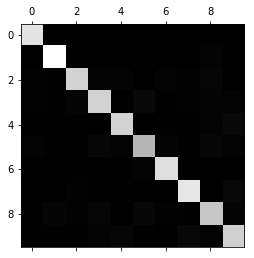

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
confus_mtx = confusion_matrix(y_train,y_train_pred)
confus_mtx
# Looking at the image representation of the confusion matrix using matplotlib matshow function.
plt.matshow(confus_mtx, cmap = plt.cm.gray)
plt.show()
# The confusion matrix looks good since most the images are mainly on the diagonal.

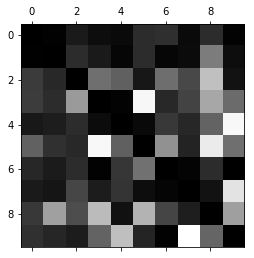

In [24]:
# Let us focus on the error plots. divide each value with in confusion matrix with the number of images in the corresponding class.
# So we can compare the error rates instead of absolute numbers.
row_sums = confus_mtx.sum(axis = 1, keepdims = True)
norm_conf_mx = confus_mtx.astype(float) / row_sums
# lets fill the diagonal elements with zeros to keep only errors.
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

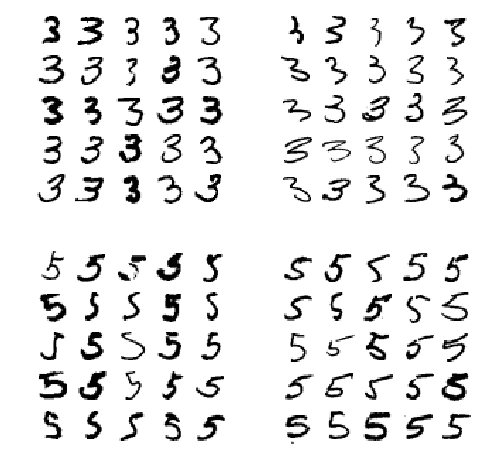

In [25]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification
Until now each instance has been assigned a single output class. In some cases you may want your classifier to output multiple classes for each instance. For eg, consider a face recognition classifier: what should it do if recognises several people in the same picture? Then it should attached one label per person. Say it is trained to classify three labels then, for picture it may give output as [1,0,1] ie 1 and 3 are present and 2 is absent. A classification system that output multiple binary labels is called a multilabel classification. 

In [26]:
from sklearn.neighbors import KNeighborsClassifier
# Supports multilabel classification.
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]
# y_multilabel
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [27]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [28]:
# y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_train,cv=3)
# f1_score(y_train, y_train_knn_pred, average = "macro")

In [32]:
import numpy.random as rnd
noise = rnd.randint(0, 100, (len(X_train), 784))
noise2 = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise2
y_train_mod = X_train
y_test_mod = X_test

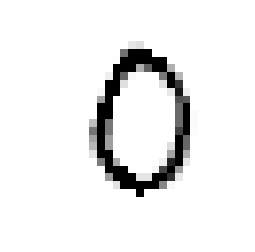

In [36]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[12]])
plot_digits(clean_digit)

### Excercise